# Style Transfer Learning
Our final lab consists of an implementation of style transfer learning in PyTorch.
A short recap:
1. Load a pre-trained VGG-16 model
2. Identify which filters correspond to style and content
3. Modify an input image to minimize style loss and content loss.

## 0 Load the libraries and download model
Apart from pytorch, we are going to load torchvision: It consists of popular datasets, model architectures, and common image transformations for computer vision.

In [1]:
import time
import os

import json

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

import VGG

import matplotlib.pyplot as plt
%matplotlib inline

## 1 Load configuration and model

In [2]:
config = {"MODEL": {
            "DIR": "./",
            "FILENAME": "vgg_conv.pth"
            },
        "IMAGES": {
            "DIR": "./",
            "STYLE_TEMPLATE": "style.jpg",
            "CONTENT_TEMPLATE": "content.jpg",
            "OUTPUT": "out.jpg",
            "SIZE": 500
        },
        "ITERATION": {
            "MAX_ITER": 1000,
            "SHOW_ITER": 50
        },
        "LAYERS":{
            "STYLE": ["r11","r21","r31","r41", "r51"],
            "CONTENT": ["r42"]
        }
    }

print(config)

{'MODEL': {'DIR': './', 'FILENAME': 'vgg_conv.pth'}, 'IMAGES': {'DIR': './', 'STYLE_TEMPLATE': 'style.jpg', 'CONTENT_TEMPLATE': 'content.jpg', 'OUTPUT': 'out.jpg', 'SIZE': 500}, 'ITERATION': {'MAX_ITER': 1000, 'SHOW_ITER': 50}, 'LAYERS': {'STYLE': ['r11', 'r21', 'r31', 'r41', 'r51'], 'CONTENT': ['r42']}}


In [3]:
def load_model(config):
    'load model'
    model = VGG.VGG()
    model_dir = config['MODEL']['DIR']
    model_filename = config['MODEL']['FILENAME']
    model.load_state_dict(torch.load(os.path.join(model_dir, model_filename)))
    for param in model.parameters():
        param.requires_grad = False
    if torch.cuda.is_available():
        model.cuda()
    return model

In [4]:
model = load_model(config)
print(model)

VGG(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512,

## 2 Define auxiliary functions
To compute content and style losses, it is required to implement functions that return Gram matrices of a set of vectors.

In [5]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1, 2))
        G.div_(h*w)
        return G


class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

## 3 Define Pre- and Postprocessing
For **preprocessing** we need to resize the images to a desired size, transform their colour space from RGB to BGR, and normalise the images to a standard. The subtracted mean is taken from the image database *imagenet*.

For **postprocessing** we need to invert the normalization and change back to the RGB colourspace.

In [6]:
def get_pre_post_processing(config):
    'Define Pre-Processing (func)'
    preproc = transforms.Compose([transforms.Resize(config["IMAGES"]["SIZE"]),
                                  transforms.ToTensor(),
                                  transforms.Lambda(
        lambda x: x[torch.LongTensor([2, 1, 0])]),  # RGB2BGR
        transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961],  
                             std=[1, 1, 1]),
        transforms.Lambda(lambda x: x.mul_(255)),
    ])

    'Define Post-Processing (func)'
    postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                                 transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961],  # add imagenet mean
                                                      std=[1, 1, 1]),
                                 transforms.Lambda(
                                     lambda x: x[torch.LongTensor([2, 1, 0])]),  # BGR2RGB
                                 ])

    postpb = transforms.Compose([transforms.ToPILImage()])

    def postproc(tensor):  # cutoff
        t = postpa(tensor)
        t[t > 1] = 1
        t[t < 0] = 0
        img = postpb(t)
        return img

    return preproc, postproc

In [7]:
preproc, postproc = get_pre_post_processing(config)

## 4 Load images
Now we load the images from the drive. The output image will be initialised to the content template.

In [8]:
def load_images(config, prep):
    '''load images, ordered as [style_image, content_image]'''
    image_dir = config['IMAGES']['DIR']
    image_names = [config['IMAGES']['STYLE_TEMPLATE'],
                   config['IMAGES']['CONTENT_TEMPLATE']]
    imgs = [Image.open(os.path.join(image_dir, name)) for name in image_names]
    
    # show images
    plt.figure()
    plt.imshow(imgs[0])
    plt.title('Style template')
    plt.figure()
    plt.imshow(imgs[1])
    plt.title('Content template')
    
    imgs_torch = [prep(img) for img in imgs]
    if torch.cuda.is_available():
        imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
    else:
        imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
    style_image, content_image = imgs_torch

    opt_img = Variable(content_image.data.clone(), requires_grad=True)
    return opt_img, style_image, content_image

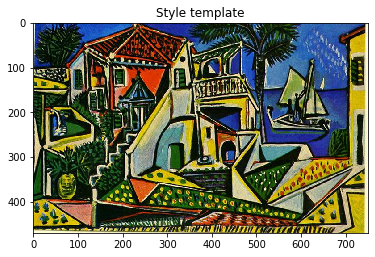

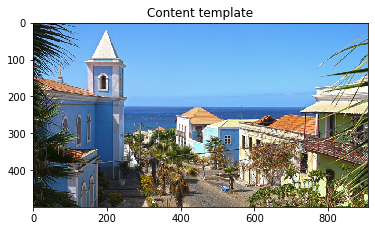

In [9]:
opt_img, style_image, content_image = load_images(config, preproc)

## 5 Define style and content weights
The weights are taken from the paper Gatys et al.: Image Style Transfer Using Convolutional Neural Networks, 2016.

In [10]:
def get_weights():
    style_weights = [1e3/n**2 for n in [64, 128, 256, 512, 512]]
    content_weights = [1e0]
    weights = style_weights + content_weights
    return weights

In [11]:
weights = get_weights()
print(weights)

[0.244140625, 0.06103515625, 0.0152587890625, 0.003814697265625, 0.003814697265625, 1.0]


## 6 Define loss function and weights
This is a crucial step: We implement the combination between content loss and style loss.

In [12]:
def get_loss(config):
    style_layers = config['LAYERS']['STYLE']
    content_layers = config['LAYERS']['CONTENT']
    loss_layers = style_layers + content_layers
    loss_fns = [GramMSELoss()] * len(style_layers) + \
        [nn.MSELoss()] * len(content_layers)
    if torch.cuda.is_available():
        loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    return loss_fns, loss_layers

In [13]:
loss_fns, loss_layers = get_loss(config)

In [14]:
def targets(config, style_image, content_image, model):
    '''compute loss functions'''
    style_layers = config['LAYERS']['STYLE']
    content_layers = config['LAYERS']['CONTENT']
    
    style_targets = [GramMatrix()(A).detach()
                     for A in model(style_image, style_layers)]
    content_targets = [A.detach()
                       for A in model(content_image, content_layers)]
    
    targets = style_targets + content_targets
    return targets

In [15]:
targets = targets(config, style_image, content_image, model)

print(targets)

[tensor([[[ 6689.3022,   612.6426,  1190.6573,  ...,  3399.0786,
           2408.2397,  3273.8740],
         [  612.6426,  1687.4845,   543.0206,  ...,   669.9540,
            474.8578,   460.3552],
         [ 1190.6573,   543.0206,   695.6273,  ...,   236.9492,
            967.8942,  1216.1421],
         ...,
         [ 3399.0786,   669.9540,   236.9492,  ..., 26227.7109,
           2207.9500,  1233.3418],
         [ 2408.2397,   474.8578,   967.8942,  ...,  2207.9500,
           3466.5862,  3085.0498],
         [ 3273.8740,   460.3552,  1216.1421,  ...,  1233.3418,
           3085.0498,  3529.5146]]], device='cuda:0'), tensor([[[2.2679e+03, 5.4348e+02, 3.6649e+01,  ..., 2.0961e+03,
          2.2034e+03, 6.9423e+02],
         [5.4348e+02, 8.5620e+04, 3.6536e+04,  ..., 7.4134e+04,
          6.4512e+04, 3.8993e+04],
         [3.6649e+01, 3.6536e+04, 1.9630e+05,  ..., 1.1850e+05,
          2.8812e+04, 5.1655e+04],
         ...,
         [2.0961e+03, 7.4134e+04, 1.1850e+05,  ..., 2.1751e+

## 7 The main functions
Now we have gathered all ingredients necessary to define a main function for style transfer. As an optimizer, we use a Quasi-Newton method called the [Limited-Memory Broyden–Fletcher–Goldfarb–Shanno (LMBFGS)](https://en.wikipedia.org/wiki/Limited-memory_BFGS) Algorithm, again following the aforementioned paper and implementation by Leon Gatys et al.

In [16]:
def run(config, model, opt_img, loss_layers, weights, loss_fns, targets, postproc):
    max_iter = config["ITERATION"]["MAX_ITER"]
    optimizer = optim.LBFGS([opt_img])
    n_iter = [0]

    max_iter = config['ITERATION']['MAX_ITER']
    show_iter = config['ITERATION']['SHOW_ITER']

    while n_iter[0] <= max_iter:
        def closure():
            optimizer.zero_grad()
            out = model(opt_img, loss_layers)
            layer_losses = [weights[a] * loss_fns[a]
                            (A, targets[a]) for a, A in enumerate(out)]
            loss = sum(layer_losses)
            loss.backward()
            n_iter[0] += 1
            if n_iter[0] % show_iter == (show_iter-1):
                print('Iteration: {}, loss: {}'.format(
                    n_iter[0]+1, loss.item()))
            return loss

        optimizer.step(closure)
    out_img = postproc(opt_img.data[0].cpu().squeeze())
    out_img.save(os.path.join(config['IMAGES']['DIR'], config['IMAGES']['OUTPUT']))
    return out_img

In [17]:
out = run(config, model, opt_img, loss_layers,
              weights, loss_fns, targets, postproc)

Iteration: 50, loss: 7340924.5
Iteration: 100, loss: 2796579.75
Iteration: 150, loss: 1678421.75
Iteration: 200, loss: 1263602.25
Iteration: 250, loss: 1053827.0
Iteration: 300, loss: 930402.875
Iteration: 350, loss: 848422.25
Iteration: 400, loss: 795187.25
Iteration: 450, loss: 757413.75
Iteration: 500, loss: 730358.9375
Iteration: 550, loss: 708941.4375
Iteration: 600, loss: 692174.25
Iteration: 650, loss: 678056.25
Iteration: 700, loss: 666828.5
Iteration: 750, loss: 657499.0625
Iteration: 800, loss: 649675.75
Iteration: 850, loss: 642650.375
Iteration: 900, loss: 636840.8125
Iteration: 950, loss: 631646.3125
Iteration: 1000, loss: 626969.125


## 8 Visualisation

Text(0.5, 1.0, 'Pablo Picasso: Ilha do Fogo, 2019')

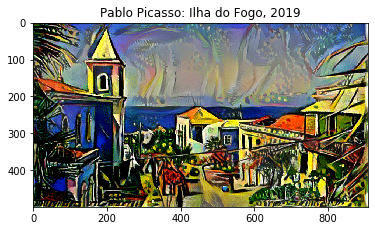

In [19]:
plt.imshow(out)
plt.title("Pablo Picasso: Ilha do Fogo, 2019")